### What is the effect of applying the Gaussian filter before curve fitting? 

By: Liviu Moanta

In [1]:
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit

In [2]:
# OpenML dataset ID
# This indicates which dataset is used
dataset_ids = [3, 6, 11, 12, 14, 15, 16, 18, 22, 23, 28, 29, 31, 32, 37, 38, 44, 46, 50, 54, 151, 182, 188, 300, 307, 458, 469, 554, 1049, 1050, 1053, 1063, 1067, 1068, 1461, 1462, 1464, 1468, 1475, 1478, 1480, 1485, 1486, 1487, 1489, 1494, 1497, 1501, 1510, 1590, 4134, 4534, 4538, 6332, 23381, 23517, 40499, 40668, 40670, 40701, 40923, 40927, 40966, 40975, 40978, 40979, 40982, 40983, 40984, 40994, 40996, 41027]

# anchor definition
# Anchor is a different term for the training set size 
anchor_list_denser = np.ceil(16 * 2 ** ((np.arange(137)) / 8)).astype(int)

# learners
# Different machine learning algorithms
learner_zoo = [ 'SVC_linear', 'SVC_poly', 'SVC_rbf', 'SVC_sigmoid', 'DecisionTree', 'ExtraTree','LogisticRegression', 'PassiveAggressive', 'Perceptron', 'RidgeClassifier', 'SGDClassifier', 'MLPClassifier', 'LDA', 'QDA', 'BernoulliNB', 'MultinomialNB', 'ComplementNB', 'GaussianNB','KNN', 'NearestCentroid', 'ens.ExtraTrees', 'ens.RandomForest', 'ens.GradientBoosting','DummyClassifier']

In [3]:
len(dataset_ids)

72

In [4]:
len(learner_zoo)

24

In [5]:
# load the error rate learning curves database 1.1
file_path = 'LCDB11_ER_CC18_noFS_real.hdf5'
with h5py.File(file_path, 'r') as hdf_file:
    dataset = hdf_file['error_rate'][...]
    print("Shape of dataset", dataset.shape)
    print("(dataset, learner, outer split, inner split, anchor, train-val-test)")

Shape of dataset (72, 24, 5, 5, 137, 3)
(dataset, learner, outer split, inner split, anchor, train-val-test)


# Learning curve from raw data vs filtered with Gaussian filters for different sigmas

Below we visualize the original learning curve and the learning curves with Gaussian filters applied with a selection of sigmas ranging from 1.0 to 16.0

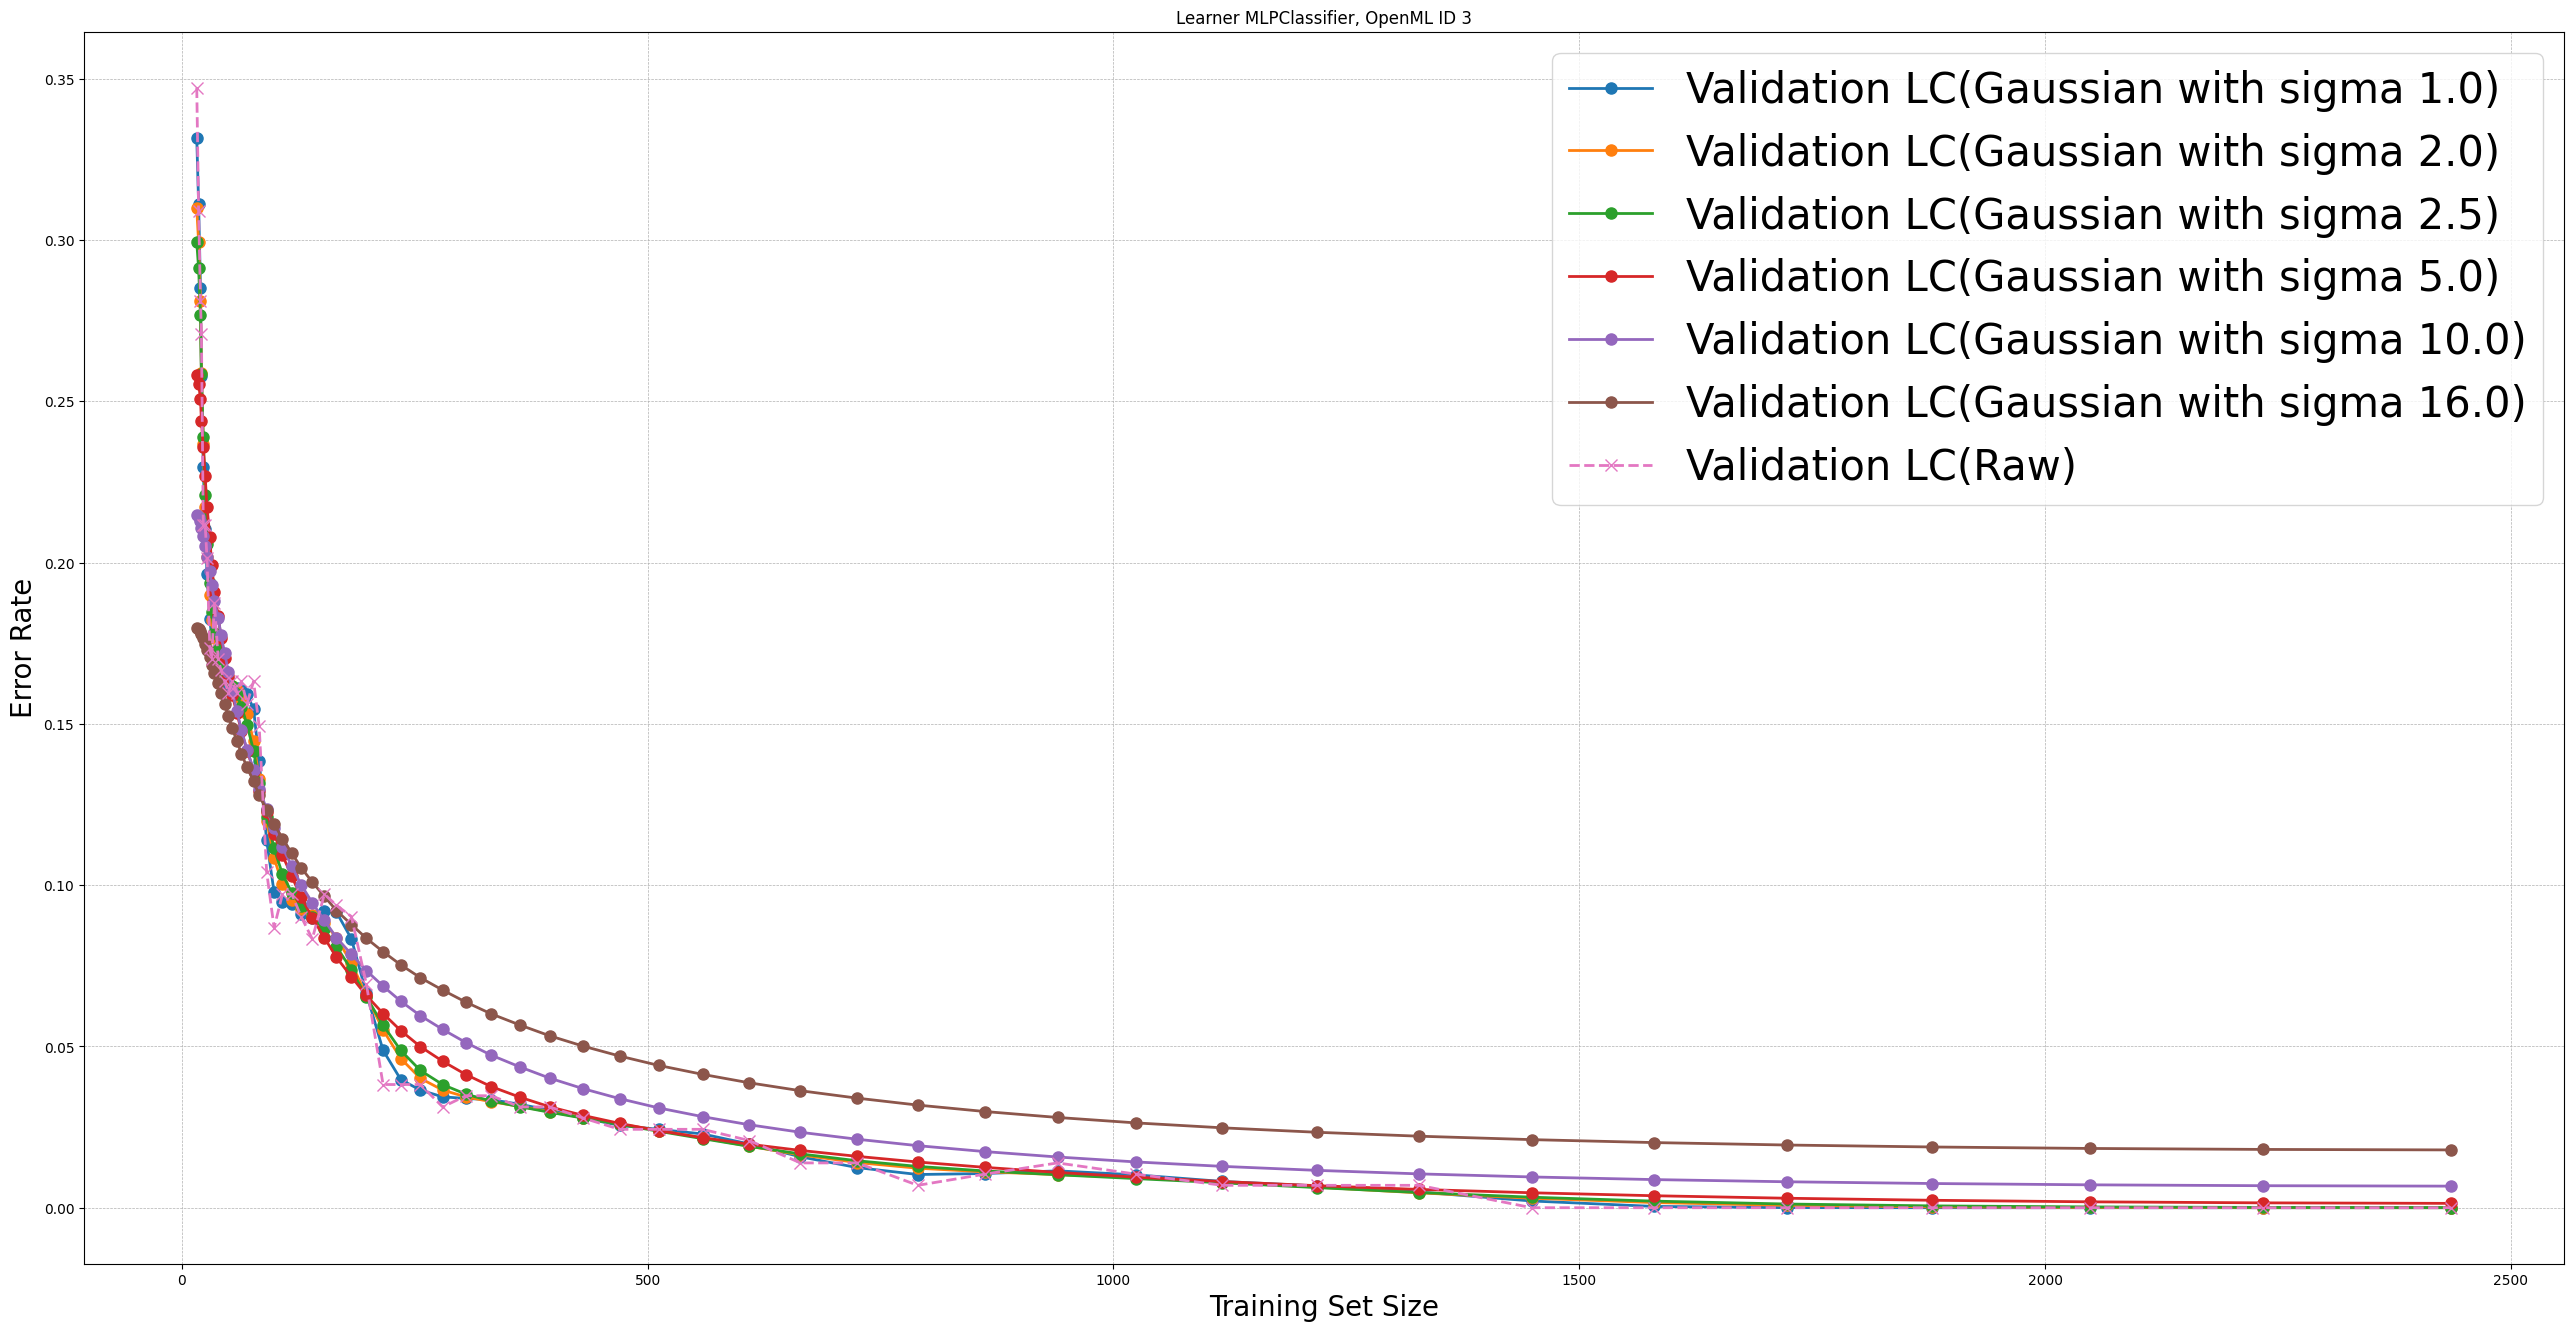

In [6]:
dataset_index = 0
learner_index = 11
outer_split = 0
inner_split = 0

SIGMA = [1.0, 2.0, 2.5, 5.0, 10.0, 16.0]

validation_error_rates = dataset[dataset_index, learner_index, outer_split, inner_split,:, 1]

first_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][0] if np.any(~np.isnan(validation_error_rates)) else -1
last_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][-1] if np.any(~np.isnan(validation_error_rates)) else -1
resized_validation_error_rates = validation_error_rates[first_non_nan_index:last_non_nan_index + 1]
resized_anchor_list_denser = anchor_list_denser[first_non_nan_index:last_non_nan_index + 1]


validation_error_rates_gaussian_filtered = dict()

for sigma in SIGMA:
    validation_error_rates_gaussian_filtered[sigma] = gaussian_filter(resized_validation_error_rates, sigma)

plt.figure(figsize=(32, 16))

for sigma, error_rates in validation_error_rates_gaussian_filtered.items():
    plt.plot(resized_anchor_list_denser, error_rates, label=f"Validation LC(Gaussian with sigma {sigma})", marker='o', markersize=8, linestyle='-', linewidth=2)
plt.plot(resized_anchor_list_denser, resized_validation_error_rates, label="Validation LC(Raw)", marker='x', markersize=8, linestyle='--', linewidth=2)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.title(f'Learner {learner_zoo[learner_index]}, OpenML ID {dataset_ids[dataset_index]}')
plt.xlabel('Training Set Size', fontsize = 20)
plt.ylabel('Error Rate', fontsize = 20)

plt.legend(fontsize=30)

plt.savefig(f'{learner_zoo[learner_index]}-{dataset_ids[dataset_index]}-filtered.png', dpi=300, bbox_inches='tight')

plt.show()

# Points and fitted learning curve, raw vs filtered

For a given dataset and learner, we visualize the raw and filtered points, along with the fitted learning curve for both raw and filtered data. 

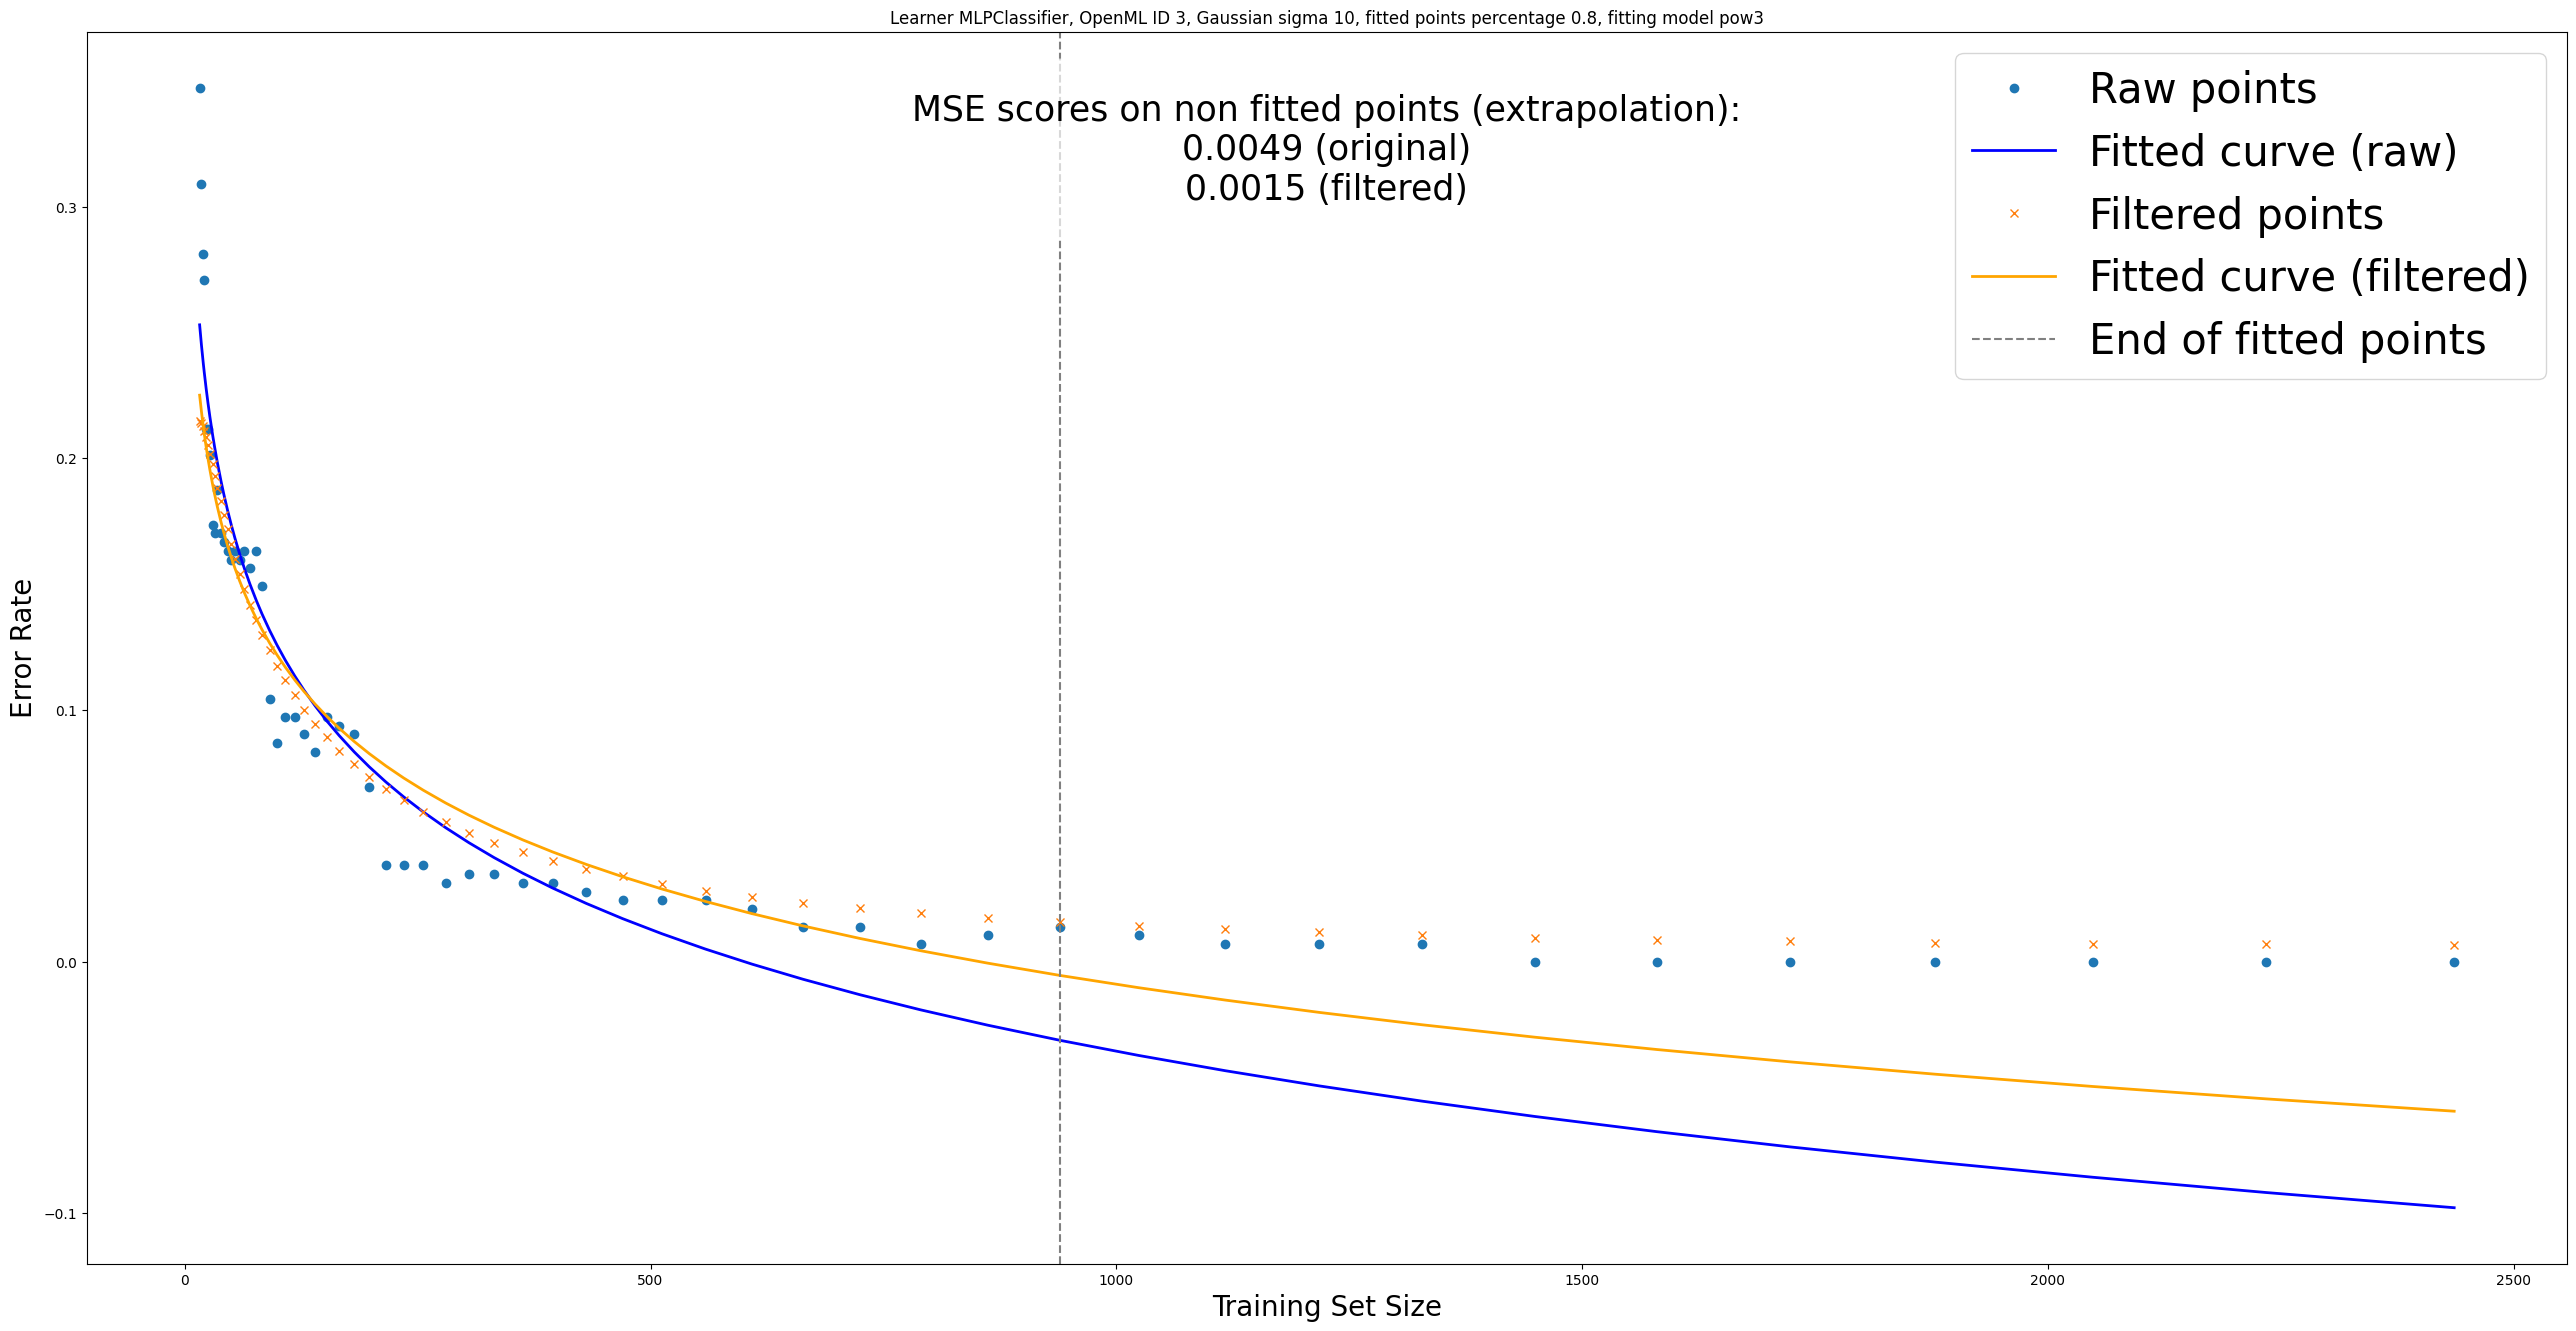

In [7]:
def exp2(x, a, b, c):
    return a * np.exp(-b * x)

def exp3(x, a, b, c):
    return a * np.exp(-b * x) + c
    
def pow3(x, a, b, c):
    return a - b * np.power(x, -c)

def logpow3(x, a, b, c):
    return a / (np.power((x * np.exp(-b)), c) + 1)

def expd3(x, a, b, c):
    return c - (-a + c) * np.exp(-b * x)

def expp3(x, a, b, c):
    return c - np.exp(np.pow(-b + x, a))

def vap3(x, a, b, c):
    return np.exp(a + b / x + c * np.log(x))


MODEL = pow3

POINTS_TO_FIT_PCT = 0.8
POINTS_TO_FIT = int(POINTS_TO_FIT_PCT * len(resized_anchor_list_denser))

SIGMA = 10


try:
    initial_guess_original = [1.0, 1.0, 0.0]
    
    opt_params_original, _ = curve_fit(MODEL, resized_anchor_list_denser[:POINTS_TO_FIT], resized_validation_error_rates[:POINTS_TO_FIT], p0=initial_guess_original, maxfev=20000)
    fit_original = MODEL(resized_anchor_list_denser, *opt_params_original)

    initial_guess_filtered = [1.0, 1.0, 0.0]
    opt_params_filtered, _ = curve_fit(MODEL, resized_anchor_list_denser[:POINTS_TO_FIT], validation_error_rates_gaussian_filtered[SIGMA][:POINTS_TO_FIT], p0=initial_guess_filtered, maxfev=20000)
    fit_filtered = MODEL(resized_anchor_list_denser, *opt_params_filtered)

    plt.figure(figsize=(32, 16))

    plt.plot(resized_anchor_list_denser, resized_validation_error_rates, label="Raw points", marker='o', markersize=6, linestyle='none')
    plt.plot(resized_anchor_list_denser, fit_original, label="Fitted curve (raw)", color='blue', linestyle='-', linewidth=2)

    plt.plot(resized_anchor_list_denser, validation_error_rates_gaussian_filtered[SIGMA], label="Filtered points", marker='x', markersize=6, linestyle='none')
    plt.plot(resized_anchor_list_denser, fit_filtered, label="Fitted curve (filtered)", color='orange', linestyle='-', linewidth=2)

    plt.title(f'Learner {learner_zoo[learner_index]}, OpenML ID {dataset_ids[dataset_index]}, Gaussian sigma {SIGMA}, fitted points percentage {POINTS_TO_FIT_PCT}, fitting model {MODEL.__name__}')
    plt.xlabel('Training Set Size', fontsize = 20)
    plt.ylabel('Error Rate', fontsize = 20)

    plt.axvline(x=resized_anchor_list_denser[POINTS_TO_FIT], color='gray', linestyle='--', label="End of fitted points")

    plt.legend(fontsize = 30)
    mse_original_nonfitted = mean_squared_error(resized_validation_error_rates[POINTS_TO_FIT:], fit_original[POINTS_TO_FIT:])
    mse_filtered_nonfitted = mean_squared_error(resized_validation_error_rates[POINTS_TO_FIT:], fit_filtered[POINTS_TO_FIT:])
    
    mse_text = f"MSE scores on non fitted points (extrapolation):\n{mse_original_nonfitted:.4f} (original)\n{mse_filtered_nonfitted:.4f} (filtered)"
    plt.text(0.5, 0.95, mse_text, transform=plt.gca().transAxes, fontsize=25,
         verticalalignment='top', horizontalalignment='center', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=1'))
    
    plt.savefig(f'{learner_zoo[learner_index]}-{dataset_ids[dataset_index]}-{SIGMA}-{POINTS_TO_FIT}-{MODEL.__name__}-fitted-extrapolation.png', dpi=300, bbox_inches='tight')

    plt.show()
except RuntimeError as e:
    print(f"Fitting failed: {e}")

In [24]:
import warnings
warnings.filterwarnings("ignore")

outer_split = 0
inner_split = 0

POINTS_TO_FIT_PCT = 0.8

SIGMA = 16

MODEL = pow3

def compute_mses(sigma, is_interpolation, pairs):
    mse_originals = []
    mse_filtereds = []
    
    for learner_index, dataset_index in pairs:
            validation_error_rates = dataset[dataset_index, learner_index, outer_split, inner_split,:, 1]
        
            first_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][0] if np.any(~np.isnan(validation_error_rates)) else -1
            last_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][-1] if np.any(~np.isnan(validation_error_rates)) else -1
            resized_validation_error_rates = validation_error_rates[first_non_nan_index:last_non_nan_index + 1]
            resized_anchor_list_denser = anchor_list_denser[first_non_nan_index:last_non_nan_index + 1]

            validation_error_rates_gaussian_filtered = dict()
            
            validation_error_rates_gaussian_filtered[sigma] = gaussian_filter(resized_validation_error_rates, sigma)
        
            try:
                initial_guess_original = [1.0, 1.0, 0.0]
                
                POINTS_TO_FIT = int(POINTS_TO_FIT_PCT * len(resized_anchor_list_denser))
                
                opt_params_original, _ = curve_fit(MODEL, resized_anchor_list_denser[:POINTS_TO_FIT], resized_validation_error_rates[:POINTS_TO_FIT], p0=initial_guess_original, maxfev=20000)
                fit_original = MODEL(resized_anchor_list_denser, *opt_params_original)
            
                initial_guess_filtered = [1.0, 1.0, 0.0]
                opt_params_filtered, _ = curve_fit(MODEL, resized_anchor_list_denser[:POINTS_TO_FIT], validation_error_rates_gaussian_filtered[sigma][:POINTS_TO_FIT], p0=initial_guess_filtered, maxfev=20000)
                fit_filtered = MODEL(resized_anchor_list_denser, *opt_params_filtered)

                if is_interpolation == False:
                    mse_originals.append(mean_squared_error(resized_validation_error_rates[POINTS_TO_FIT:], fit_original[POINTS_TO_FIT:]))
                    mse_filtereds.append(mean_squared_error(resized_validation_error_rates[POINTS_TO_FIT:], fit_filtered[POINTS_TO_FIT:]))
                else:
                    mse_originals.append(mean_squared_error(resized_validation_error_rates[:POINTS_TO_FIT+1], fit_original[:POINTS_TO_FIT+1]))
                    mse_filtereds.append(mean_squared_error(resized_validation_error_rates[:POINTS_TO_FIT+1], fit_filtered[:POINTS_TO_FIT+1]))

                
            except RuntimeError as e:
                print(f"Fitting failed: {e}")

    return mse_originals, mse_filtereds


def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    
    return filtered_data

def boxplot_mses(is_interpolation, pairs, one_learner, sigma=SIGMA):
    mse_originals, mse_filtereds = compute_mses(sigma, is_interpolation, pairs)
    
    mse_originals_filtered = remove_outliers(mse_originals)
    mse_filtereds_filtered = remove_outliers(mse_filtereds)

    data = [mse_originals_filtered, mse_filtereds_filtered]
    labels = ["Original MSEs", "Filtered MSEs"]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.boxplot(data, labels=labels, patch_artist=True, 
               boxprops=dict(facecolor="lightblue", color="black"),
               medianprops=dict(color="red", linewidth=2),
               whiskerprops=dict(color="black"),
               capprops=dict(color="black"))

    ax.set_title("Box Plot Comparison of MSEs", fontsize=16)
    ax.set_ylabel("MSE Value")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_mses(is_interpolation, pairs, one_learner, sigma=SIGMA):
    mse_originals, mse_filtereds = compute_mses(sigma, is_interpolation, pairs)

    mse_originals_filtered = remove_outliers(mse_originals)
    mse_filtereds_filtered = remove_outliers(mse_filtereds)

    min_value = min(min(mse_originals_filtered), min(mse_filtereds_filtered))
    max_value = max(max(mse_originals_filtered), max(mse_filtereds_filtered))
    bins = np.linspace(min(min(mse_originals_filtered), min(mse_filtereds_filtered)), 
                       max(max(mse_originals_filtered), max(mse_filtereds_filtered)), 
                       30)

    hist_original, bin_edges_original = np.histogram(mse_originals_filtered, bins=bins)
    hist_filtered, bin_edges_filtered = np.histogram(mse_filtereds_filtered, bins=bins)
    overlap_hist = np.minimum(hist_original, hist_filtered)
    fig, ax = plt.subplots(figsize=(10, 6))

    for i in range(len(hist_original)):
        x_start = bin_edges_original[i]
        x_end = bin_edges_original[i+1]
        bin_width = x_end - x_start
    
        orig_val = hist_original[i]
        filt_val = hist_filtered[i]
    
        if orig_val < filt_val:
            mpl.rcParams['hatch.linewidth']=7.5
            bar = ax.bar(
                x_start, 
                orig_val, 
                width=bin_width,
                color='red',
                linewidth=1.5,
                edgecolor='black',
                hatch="/"
            )
            for patch in bar.patches:
                patch._hatch_color = mpl.colors.to_rgba('blue')
        
            ax.bar(
                x_start, 
                filt_val - orig_val, 
                bottom=orig_val, 
                width=bin_width, 
                color='red',
                edgecolor='black', 
                linewidth=1.5
            )
        
        elif orig_val == filt_val:
            mpl.rcParams['hatch.linewidth']=7.5
            bar = ax.bar(
                x_start, 
                orig_val, 
                width=bin_width,
                color='red',
                linewidth=1.5,
                edgecolor='black',
                hatch="/"
            )
            for patch in bar.patches:
                patch._hatch_color = mpl.colors.to_rgba('blue')
        else:
            mpl.rcParams['hatch.linewidth']=7.5
            bar = ax.bar(
                x_start, 
                filt_val, 
                width=bin_width,
                color='red',
                linewidth=1.5,
                edgecolor='black',
                hatch="/"
            )
            for patch in bar.patches:
                patch._hatch_color = mpl.colors.to_rgba('blue')
        
            ax.bar(
                x_start, 
                orig_val - filt_val, 
                bottom=filt_val, 
                width=bin_width, 
                color='blue',
                edgecolor='black', 
                linewidth=1.5
            )

    orig_proxy = plt.Rectangle((0, 0), 1, 1, fc="blue", edgecolor="black", linewidth=1.5)
    filt_proxy = plt.Rectangle((0, 0), 1, 1, fc="red", edgecolor="black", linewidth=1.5)

    ax.set_xlabel('MSE Value')
    ax.set_ylabel('Frequency')

    if is_interpolation == False and one_learner == True:
        ax.set_title(f'MSE raw data fitted curve (Extrapolation, learner {learner_zoo[learner_index]}, model {MODEL.__name__}, fitted points percentage {POINTS_TO_FIT_PCT}, sigma {sigma})')
    elif is_interpolation == True and one_learner == True:
        ax.set_title(f'MSE raw data fitted curve (Interpolation, learner {learner_zoo[learner_index]}, model {MODEL.__name__}, fitted points percentage {POINTS_TO_FIT_PCT}, sigma {sigma})')
    
    if is_interpolation == False and one_learner == False:
        ax.set_title(f'MSE raw data fitted curve (Extrapolation, fitted points percentage {POINTS_TO_FIT_PCT}, sigma {sigma}, model {MODEL.__name__})')
    elif is_interpolation == True and one_learner == False:
        ax.set_title(f'MSE raw data fitted curve (Interpolation, fitted points percentage {POINTS_TO_FIT_PCT}, sigma {sigma}, model {MODEL.__name__})')
    
    ax.grid(True)
    ax.legend([orig_proxy, filt_proxy], ["Original", "Filtered"])

    plt.show()
    print("MannWhitney U")
    stat, p_value = stats.mannwhitneyu(mse_originals, mse_filtereds)
    print(f"Statistic: {stat}")
    print(f"P value: {p_value}")

# Mean MSEs comparison: noisy vs smooth, interpolation vs extrapolation

0.010817354520116975
0.007386048747575634
1.8117800782437089e-06
1.4710606069234489e-06
0.007951454093062327
0.007863575699854148
7.849974164320506e-06
7.85176191694232e-06


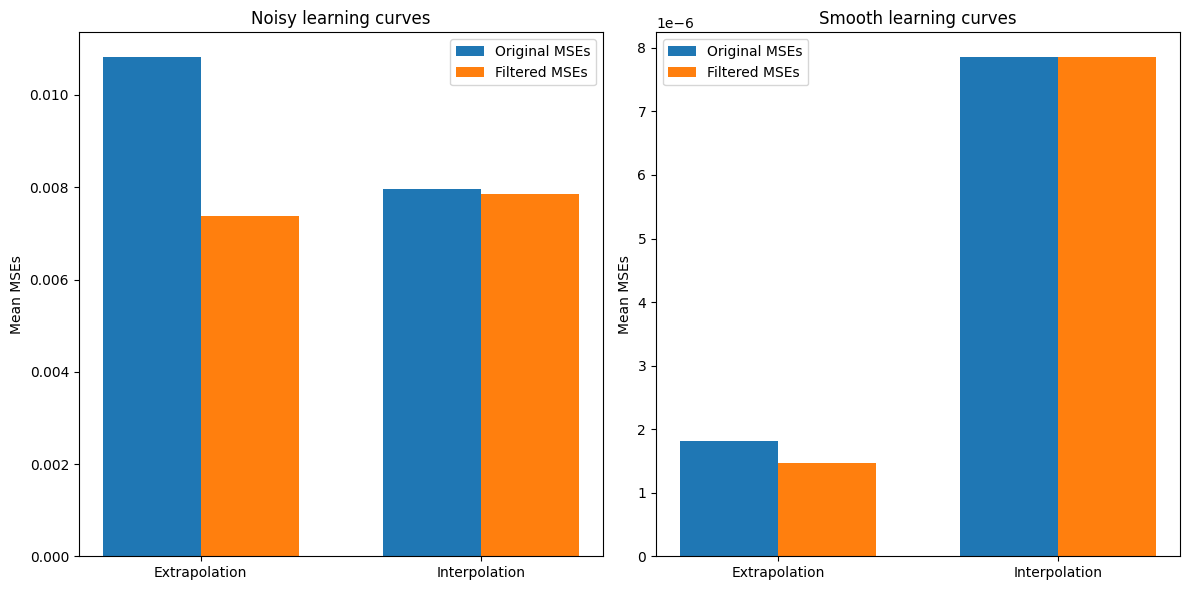

In [25]:
noisy_extrapolation_pairs = [(0, 11), (0, 22), (8, 48), (7, 62), (7, 11), (10, 40), (10, 62), (10, 19), (8, 31), (0, 14), (10, 48), (0, 28), (8, 14), (8, 66), (8, 22), (11, 12), (4, 53), (10, 22), (7, 19), (11, 22), (13, 18), (8, 40), (8, 32), (0, 66), (5, 54), (10, 66), (8, 19), (12, 54), (7, 22), (5, 22), (0, 48), (10, 31), (8, 62), (0, 33), (8, 45), (22, 53), (5, 53), (8, 54), (0, 31), (10, 54), (0, 40), (10, 45), (10, 14), (7, 66), (11, 53), (0, 19), (5, 24), (8, 24), (11, 32), (7, 68), (7, 14), (5, 40), (8, 18), (5, 12), (10, 18), (4, 54), (12, 53), (7, 54), (7, 28), (8, 5)]
smooth_extrapolation_pairs = [(18, 35), (23, 37), (17, 63), (18, 25), (21, 25), (23, 9), (23, 12), (23, 33), (23, 45), (20, 25), (18, 43), (23, 28), (23, 35), (20, 35), (22, 33), (23, 29), (23, 1), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 32), (23, 63), (23, 65), (23, 66), (23, 10), (23, 41), (23, 43), (23, 17), (23, 58), (23, 64), (23, 0), (23, 52), (23, 15), (23, 50), (23, 46), (23, 16), (23, 59), (23, 67), (23, 13), (23, 44), (23, 56), (23, 21), (23, 38), (23, 23), (23, 39), (23, 30), (23, 51), (23, 60), (23, 55), (23, 42), (23, 20), (23, 34), (23, 71), (23, 49), (23, 27), (23, 61), (23, 57), (23, 70)]
noisy_interpolation_pairs = [(0, 11), (0, 22), (8, 48), (7, 62), (7, 11), (10, 40), (10, 62), (10, 19), (8, 31), (0, 14), (10, 48), (0, 28), (8, 14), (8, 66), (8, 22), (11, 12), (4, 53), (10, 22), (7, 19), (11, 22), (13, 18), (8, 40), (8, 32), (0, 66), (5, 54), (10, 66), (8, 19), (12, 54), (7, 22), (5, 22), (0, 48), (10, 31), (8, 62), (0, 33), (8, 45), (22, 53), (5, 53), (8, 54), (0, 31), (10, 54), (0, 40), (10, 45), (10, 14), (7, 66), (11, 53), (0, 19), (5, 24), (8, 24), (11, 32), (7, 68), (7, 14), (5, 40), (8, 18), (5, 12), (10, 18), (4, 54), (12, 53), (7, 54), (7, 28), (8, 5)]
smooth_interpolation_pairs = [(18, 35), (23, 37), (17, 63), (18, 25), (21, 25), (23, 9), (23, 12), (23, 33), (23, 45), (20, 25), (18, 43), (23, 28), (23, 35), (20, 35), (22, 33), (23, 29), (23, 1), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 32), (23, 63), (23, 65), (23, 66), (23, 10), (23, 41), (23, 43), (23, 17), (23, 58), (23, 64), (23, 0), (23, 52), (23, 15), (23, 50), (23, 46), (23, 16), (23, 59), (23, 67), (23, 13), (23, 44), (23, 56), (23, 21), (23, 38), (23, 23), (23, 39), (23, 30), (23, 51), (23, 60), (23, 55), (23, 42), (23, 20), (23, 34), (23, 71), (23, 49), (23, 27), (23, 61), (23, 57), (23, 70)]

noisy_extrapolation_original_mses, noisy_extrapolation_filtered_mses = compute_mses(16.0, False, noisy_extrapolation_pairs)
smooth_extrapolation_original_mses, smooth_extrapolation_filtered_mses = compute_mses(16.0, False, smooth_extrapolation_pairs)
noisy_interpolation_original_mses, noisy_interpolation_filtered_mses = compute_mses(2.0, True, noisy_interpolation_pairs)
smooth_interpolation_original_mses, smooth_interpolation_filtered_mses = compute_mses(2.0, True, smooth_interpolation_pairs)

mean_noisy_extrapolation_original_mses = np.mean(remove_outliers(noisy_extrapolation_original_mses))
print(mean_noisy_extrapolation_original_mses)
mean_noisy_extrapolation_filtered_mses = np.mean(remove_outliers(noisy_extrapolation_filtered_mses))
print(mean_noisy_extrapolation_filtered_mses)
mean_smooth_extrapolation_original_mses = np.mean(remove_outliers(smooth_extrapolation_original_mses))
print(mean_smooth_extrapolation_original_mses)
mean_smooth_extrapolation_filtered_mses = np.mean(remove_outliers(smooth_extrapolation_filtered_mses))
print(mean_smooth_extrapolation_filtered_mses)
mean_noisy_interpolation_original_mses = np.mean(remove_outliers(noisy_interpolation_original_mses))
print(mean_noisy_interpolation_original_mses)
mean_noisy_interpolation_filtered_mses = np.mean(remove_outliers(noisy_interpolation_filtered_mses))
print(mean_noisy_interpolation_filtered_mses)
mean_smooth_interpolation_original_mses = np.mean(remove_outliers(smooth_interpolation_original_mses))
print(mean_smooth_interpolation_original_mses)
mean_smooth_interpolation_filtered_mses = np.mean(remove_outliers(smooth_interpolation_filtered_mses))
print(mean_smooth_interpolation_filtered_mses)

categories = [
    "Noisy Extrapolation",
    "Smooth Extrapolation",
    "Noisy Interpolation",
    "Smooth Interpolation",
]

original_mses = [
    mean_noisy_extrapolation_original_mses,
    mean_smooth_extrapolation_original_mses,
    mean_noisy_interpolation_original_mses,
    mean_smooth_interpolation_original_mses,
]

filtered_mses = [
    mean_noisy_extrapolation_filtered_mses,
    mean_smooth_extrapolation_filtered_mses,
    mean_noisy_interpolation_filtered_mses,
    mean_smooth_interpolation_filtered_mses,
]

x_noisy = np.array([0, 1])
x_smooth = np.array([0, 1])

width = 0.35

fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 1]})
axs[0].bar(
    x_noisy - width / 2,
    [mean_noisy_extrapolation_original_mses, mean_noisy_interpolation_original_mses],
    width,
    label="Original MSEs",
)
axs[0].bar(
    x_noisy + width / 2,
    [mean_noisy_extrapolation_filtered_mses, mean_noisy_interpolation_filtered_mses],
    width,
    label="Filtered MSEs",
)
axs[0].set_title("Noisy learning curves")
axs[0].set_xticks(x_noisy)
axs[0].set_xticklabels(["Extrapolation", "Interpolation"])
axs[0].set_ylabel("Mean MSEs")
axs[0].legend()

axs[1].bar(
    x_smooth - width / 2,
    [mean_smooth_extrapolation_original_mses, mean_smooth_interpolation_original_mses],
    width,
    label="Original MSEs",
)
axs[1].bar(
    x_smooth + width / 2,
    [mean_smooth_extrapolation_filtered_mses, mean_smooth_interpolation_filtered_mses],
    width,
    label="Filtered MSEs",
)
axs[1].set_title("Smooth learning curves")
axs[1].set_xticks(x_smooth)
axs[1].set_xticklabels(["Extrapolation", "Interpolation"])
axs[1].set_ylabel("Mean MSEs")
axs[1].legend()

plt.tight_layout()
plt.show()

# Side-by-side noisy vs smooth MSEs distribution comparison

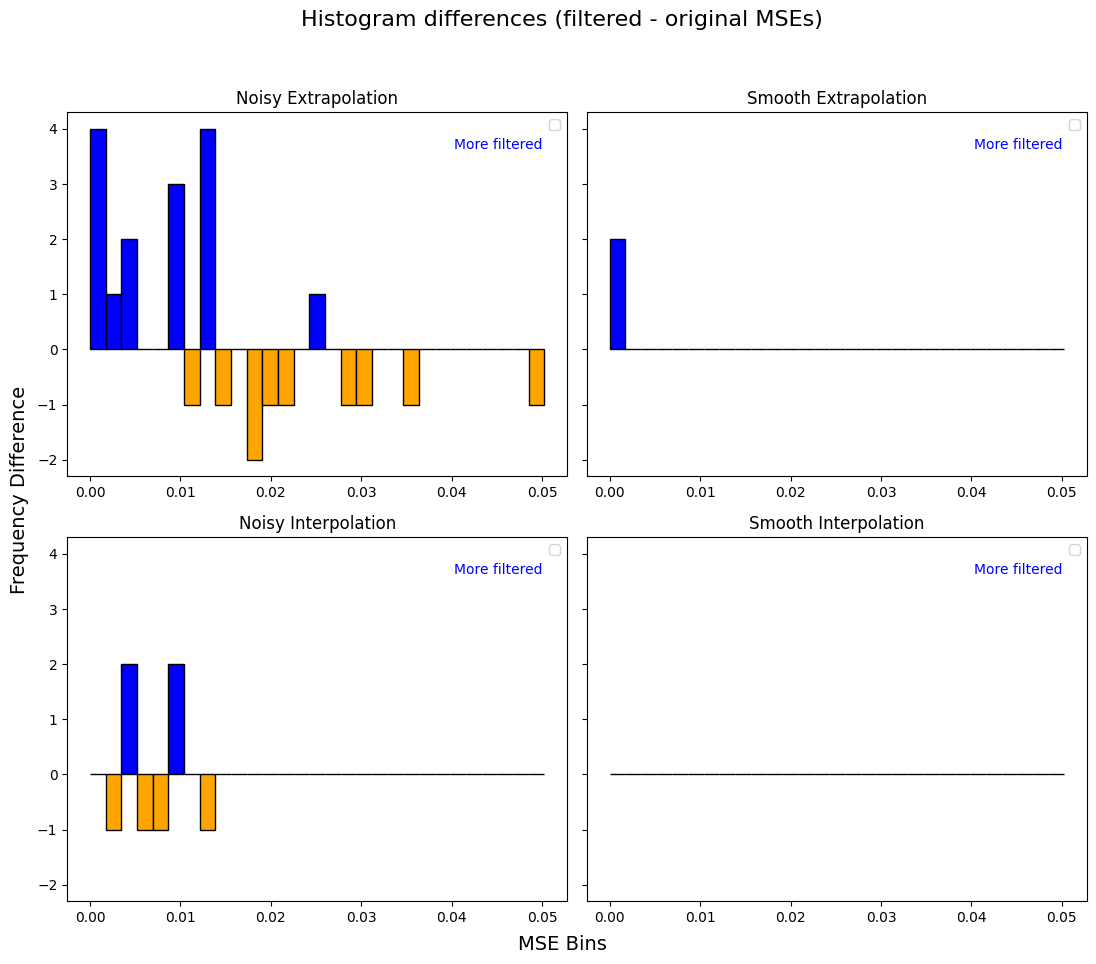

In [26]:
noisy_extrapolation_original_mses, noisy_extrapolation_filtered_mses = compute_mses(16.0, False, noisy_extrapolation_pairs)
smooth_extrapolation_original_mses, smooth_extrapolation_filtered_mses = compute_mses(16.0, False, smooth_extrapolation_pairs)
noisy_interpolation_original_mses, noisy_interpolation_filtered_mses = compute_mses(2.0, True, noisy_interpolation_pairs)
smooth_interpolation_original_mses, smooth_interpolation_filtered_mses = compute_mses(2.0, True, smooth_interpolation_pairs)

def compute_histogram_differences(original, filtered, bins):
    original_counts, _ = np.histogram(original, bins=bins)
    filtered_counts, _ = np.histogram(filtered, bins=bins)
    return filtered_counts - original_counts

all_data = np.concatenate([
    remove_outliers(noisy_extrapolation_original_mses),
    remove_outliers(noisy_extrapolation_filtered_mses),
    remove_outliers(smooth_extrapolation_original_mses),
    remove_outliers(smooth_extrapolation_filtered_mses),
    remove_outliers(noisy_interpolation_original_mses),
    remove_outliers(noisy_interpolation_filtered_mses),
    remove_outliers(smooth_interpolation_original_mses),
    remove_outliers(smooth_interpolation_filtered_mses),
])
bins = np.linspace(min(all_data), max(all_data), 30)

noisy_extrapolation_diff = compute_histogram_differences(
    remove_outliers(noisy_extrapolation_original_mses), remove_outliers(noisy_extrapolation_filtered_mses), bins
)
smooth_extrapolation_diff = compute_histogram_differences(
    remove_outliers(smooth_extrapolation_original_mses), remove_outliers(smooth_extrapolation_filtered_mses), bins
)
noisy_interpolation_diff = compute_histogram_differences(
    remove_outliers(noisy_interpolation_original_mses), remove_outliers(noisy_interpolation_filtered_mses), bins
)
smooth_interpolation_diff = compute_histogram_differences(
   remove_outliers( smooth_interpolation_original_mses), remove_outliers(smooth_interpolation_filtered_mses), bins
)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

def annotate_axes(ax):
    ax.text(0.95, 0.9, "More filtered", transform=ax.transAxes, color="blue", fontsize=10, ha='right')

axes[0, 0].bar(bin_centers, noisy_extrapolation_diff, width=np.diff(bins), color=['blue' if x > 0 else 'orange' for x in noisy_extrapolation_diff], edgecolor='black')
axes[0, 0].set_title("Noisy Extrapolation")
annotate_axes(axes[0, 0])
axes[0, 0].legend()

axes[0, 1].bar(bin_centers, smooth_extrapolation_diff, width=np.diff(bins), color=['blue' if x > 0 else 'orange' for x in smooth_extrapolation_diff], edgecolor='black')
axes[0, 1].set_title("Smooth Extrapolation")
annotate_axes(axes[0, 1])
axes[0, 1].legend()

axes[1, 0].bar(bin_centers, noisy_interpolation_diff, width=np.diff(bins), color=['blue' if x > 0 else 'orange' for x in noisy_interpolation_diff], edgecolor='black')
axes[1, 0].set_title("Noisy Interpolation")
annotate_axes(axes[1, 0])
axes[1, 0].legend()

axes[1, 1].bar(bin_centers, smooth_interpolation_diff, width=np.diff(bins), color=['blue' if x > 0 else 'orange' for x in smooth_interpolation_diff], edgecolor='black')
axes[1, 1].set_title("Smooth Interpolation")
annotate_axes(axes[1, 1])
axes[1, 1].legend()

fig.suptitle("Histogram differences (filtered - original MSEs)", fontsize=16)
fig.text(0.5, 0.04, "MSE Bins", ha='center', fontsize=14)
fig.text(0.04, 0.5, "Frequency Difference", va='center', rotation='vertical', fontsize=14)

plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])
plt.show()

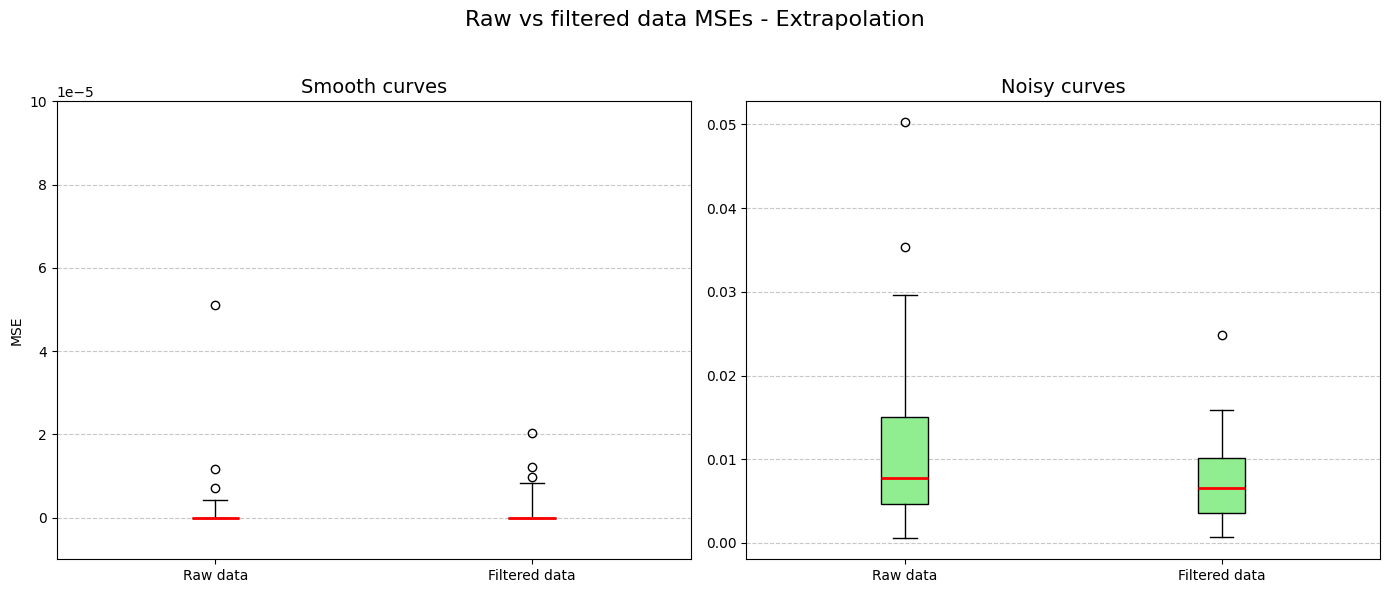

In [27]:
def boxplot_2_mse(is_interpolation, case, pairs1, pairs2, one_learner, sigma=SIGMA):
    mse_originals1, mse_filtereds1 = compute_mses(sigma, is_interpolation, pairs1)
    
    mse_originals_filtered1 = remove_outliers(mse_originals1)
    mse_filtereds_filtered1 = remove_outliers(mse_filtereds1)
    
    mse_originals2, mse_filtereds2 = compute_mses(sigma, is_interpolation, pairs2)
    
    mse_originals_filtered2 = remove_outliers(mse_originals2)
    mse_filtereds_filtered2 = remove_outliers(mse_filtereds2)

    data1 = [mse_originals_filtered1, mse_filtereds_filtered1]
    labels1 = ["Raw data", "Filtered data"]

    data2 = [mse_originals_filtered2, mse_filtereds_filtered2]
    labels2 = ["Raw data", "Filtered data"]

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    axs[0].boxplot(data1, labels=labels1, patch_artist=True,whis=[0,95],
                   boxprops=dict(facecolor="lightblue", color="black"),
                   medianprops=dict(color="red", linewidth=2),
                   whiskerprops=dict(color="black"),
                   capprops=dict(color="black"))
    axs[0].set_title("Smooth curves", fontsize=14)
    axs[0].set_ylabel("MSE")
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)
    axs[0].set_ylim(-0.00001, 0.0001)

    axs[1].boxplot(data2, labels=labels2, patch_artist=True,
                   boxprops=dict(facecolor="lightgreen", color="black"),
                   medianprops=dict(color="red", linewidth=2),
                   whiskerprops=dict(color="black"),
                   capprops=dict(color="black"))
    axs[1].set_title("Noisy curves", fontsize=14)
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)

    fig.suptitle(f"Raw vs filtered data MSEs - {case}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

noisy_extrapolation = [(0, 11), (0, 22), (8, 48), (7, 62), (7, 11), (10, 40), (10, 62), (10, 19), (8, 31), (0, 14), (10, 48), (0, 28), (8, 14), (8, 66), (8, 22), (11, 12), (4, 53), (10, 22), (7, 19), (11, 22), (13, 18), (8, 40), (8, 32), (0, 66), (5, 54), (10, 66), (8, 19), (12, 54), (7, 22), (5, 22), (0, 48), (10, 31), (8, 62), (0, 33), (8, 45), (22, 53), (5, 53), (8, 54), (0, 31), (10, 54), (0, 40), (10, 45), (10, 14), (7, 66), (11, 53), (0, 19), (5, 24), (8, 24), (11, 32), (7, 68), (7, 14), (5, 40), (8, 18), (5, 12), (10, 18), (4, 54), (12, 53), (7, 54), (7, 28), (8, 5)]
smooth_extrapolation = [(18, 35), (23, 37), (17, 63), (18, 25), (21, 25), (23, 9), (23, 12), (23, 33), (23, 45), (20, 25), (18, 43), (23, 28), (23, 35), (20, 35), (22, 33), (23, 29), (23, 1), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 32), (23, 63), (23, 65), (23, 66), (23, 10), (23, 41), (23, 43), (23, 17), (23, 58), (23, 64), (23, 0), (23, 52), (23, 15), (23, 50), (23, 46), (23, 16), (23, 59), (23, 67), (23, 13), (23, 44), (23, 56), (23, 21), (23, 38), (23, 23), (23, 39), (23, 30), (23, 51), (23, 60), (23, 55), (23, 42), (23, 20), (23, 34), (23, 71), (23, 49), (23, 27), (23, 61), (23, 57), (23, 70)]

boxplot_2_mse(False, "Extrapolation", smooth_extrapolation, noisy_extrapolation, False, 16.0)

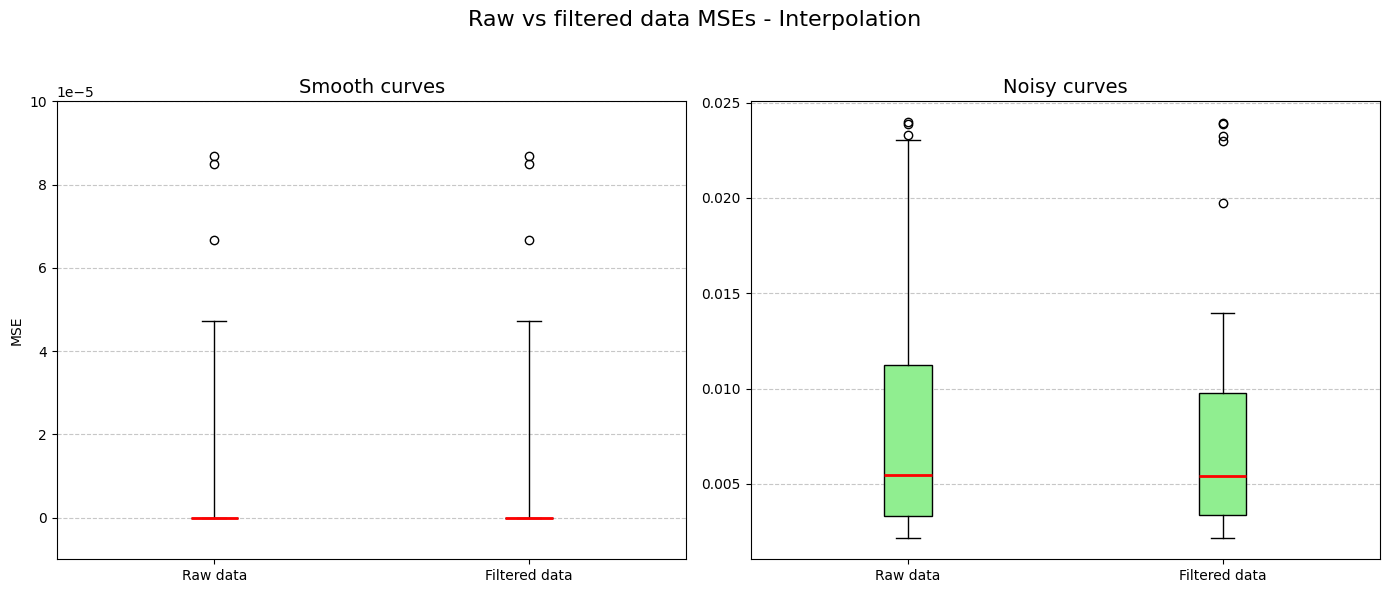

In [12]:
noisy_interpolation = [(0, 11), (0, 22), (8, 48), (7, 62), (7, 11), (10, 40), (10, 62), (10, 19), (8, 31), (0, 14), (10, 48), (0, 28), (8, 14), (8, 66), (8, 22), (11, 12), (4, 53), (10, 22), (7, 19), (11, 22), (13, 18), (8, 40), (8, 32), (0, 66), (5, 54), (10, 66), (8, 19), (12, 54), (7, 22), (5, 22), (0, 48), (10, 31), (8, 62), (0, 33), (8, 45), (22, 53), (5, 53), (8, 54), (0, 31), (10, 54), (0, 40), (10, 45), (10, 14), (7, 66), (11, 53), (0, 19), (5, 24), (8, 24), (11, 32), (7, 68), (7, 14), (5, 40), (8, 18), (5, 12), (10, 18), (4, 54), (12, 53), (7, 54), (7, 28), (8, 5)]
smooth_interpolation = [(18, 35), (23, 37), (17, 63), (18, 25), (21, 25), (23, 9), (23, 12), (23, 33), (23, 45), (20, 25), (18, 43), (23, 28), (23, 35), (20, 35), (22, 33), (23, 29), (23, 1), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 32), (23, 63), (23, 65), (23, 66), (23, 10), (23, 41), (23, 43), (23, 17), (23, 58), (23, 64), (23, 0), (23, 52), (23, 15), (23, 50), (23, 46), (23, 16), (23, 59), (23, 67), (23, 13), (23, 44), (23, 56), (23, 21), (23, 38), (23, 23), (23, 39), (23, 30), (23, 51), (23, 60), (23, 55), (23, 42), (23, 20), (23, 34), (23, 71), (23, 49), (23, 27), (23, 61), (23, 57), (23, 70)]

boxplot_2_mse(True, "Interpolation", smooth_interpolation, noisy_interpolation, False, 2.0)

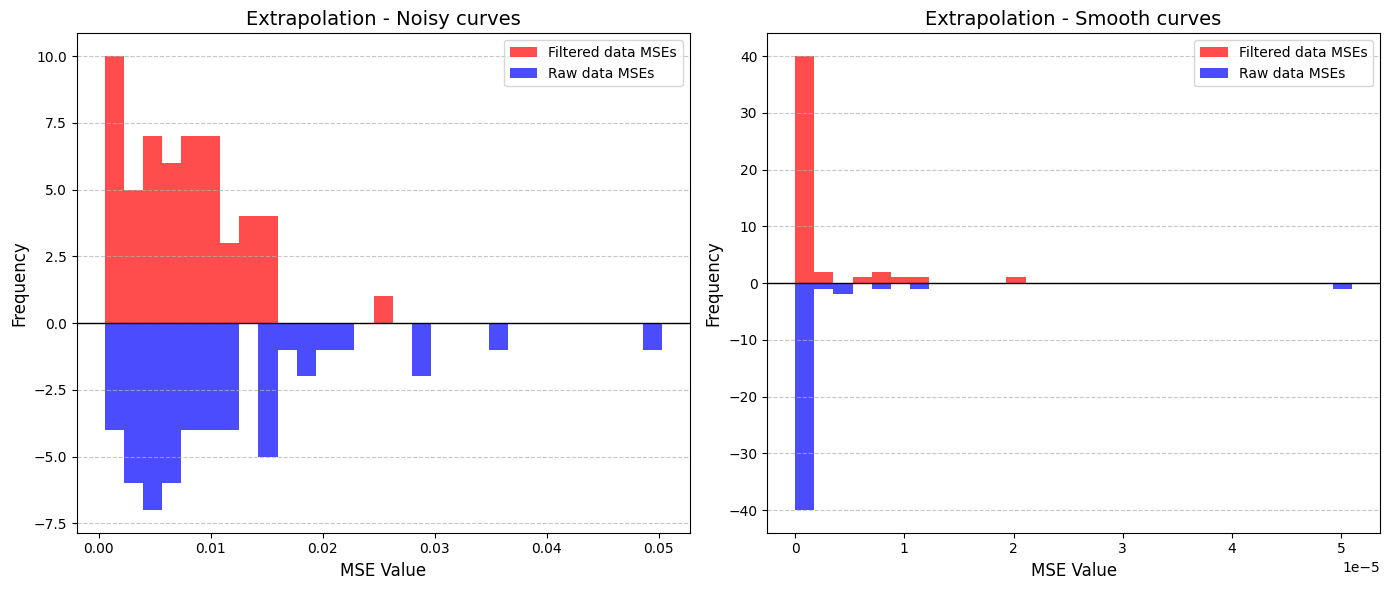

In [28]:
def plot_mirror_histogram(is_interpolation, pairs1, pairs2, one_learner, sigma):
    mse_originals1, mse_filtereds1 = compute_mses(sigma, is_interpolation, pairs1)
    
    mse_originals_filtered1 = remove_outliers(mse_originals1)
    mse_filtereds_filtered1 = remove_outliers(mse_filtereds1)
    
    mse_originals2, mse_filtereds2 = compute_mses(sigma, is_interpolation, pairs2)
    
    mse_originals_filtered2 = remove_outliers(mse_originals2)
    mse_filtereds_filtered2 = remove_outliers(mse_filtereds2)
    
    min_value = min(min(mse_originals_filtered1), min(mse_filtereds_filtered1))
    max_value = max(max(mse_originals_filtered1), max(mse_filtereds_filtered1))
        
    bins = np.linspace(min_value, max_value, 30)  # 30 bins for the histogram
    
    hist_original, bin_edges = np.histogram(mse_originals_filtered1, bins=bins)
    hist_filtered, _ = np.histogram(mse_filtereds_filtered1, bins=bins)

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].bar(bin_edges[:-1], hist_filtered, width=np.diff(bin_edges), 
           align='edge', color='red', alpha=0.7, label='Filtered data MSEs')
    axs[0].bar(bin_edges[:-1], -hist_original, width=np.diff(bin_edges), 
           align='edge', color='blue', alpha=0.7, label='Raw data MSEs')

    axs[0].axhline(0, color='black', linewidth=1)
    axs[0].set_xlabel('MSE Value', fontsize=12)
    axs[0].set_ylabel('Frequency', fontsize=12)
    if is_interpolation:
        axs[0].set_title('Interpolation - Noisy curves', fontsize=14)
    else:
        axs[0].set_title('Extrapolation - Noisy curves', fontsize=14)
    axs[0].legend(loc='upper right', fontsize=10)
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)

    min_value = min(min(mse_originals_filtered2), min(mse_filtereds_filtered2))
    max_value = max(max(mse_originals_filtered2), max(mse_filtereds_filtered2))
        
    bins = np.linspace(min_value, max_value, 30)

    hist_original, bin_edges = np.histogram(mse_originals_filtered2, bins=bins)
    hist_filtered, _ = np.histogram(mse_filtereds_filtered2, bins=bins)

    axs[1].bar(bin_edges[:-1], hist_filtered, width=np.diff(bin_edges), 
           align='edge', color='red', alpha=0.7, label='Filtered data MSEs')
    axs[1].bar(bin_edges[:-1], -hist_original, width=np.diff(bin_edges), 
           align='edge', color='blue', alpha=0.7, label='Raw data MSEs')

    axs[1].axhline(0, color='black', linewidth=1)
    axs[1].set_xlabel('MSE Value', fontsize=12)
    axs[1].set_ylabel('Frequency', fontsize=12)
    if is_interpolation:
        axs[1].set_title('Interpolation - Smooth curves', fontsize=14)
    else:
        axs[1].set_title('Extrapolation - Smooth curves', fontsize=14)
    axs[1].legend(loc='upper right', fontsize=10)
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



noisy_extrapolation = [(0, 11), (0, 22), (8, 48), (7, 62), (7, 11), (10, 40), (10, 62), (10, 19), (8, 31), (0, 14), (10, 48), (0, 28), (8, 14), (8, 66), (8, 22), (11, 12), (4, 53), (10, 22), (7, 19), (11, 22), (13, 18), (8, 40), (8, 32), (0, 66), (5, 54), (10, 66), (8, 19), (12, 54), (7, 22), (5, 22), (0, 48), (10, 31), (8, 62), (0, 33), (8, 45), (22, 53), (5, 53), (8, 54), (0, 31), (10, 54), (0, 40), (10, 45), (10, 14), (7, 66), (11, 53), (0, 19), (5, 24), (8, 24), (11, 32), (7, 68), (7, 14), (5, 40), (8, 18), (5, 12), (10, 18), (4, 54), (12, 53), (7, 54), (7, 28), (8, 5)]
smooth_extrapolation = [(18, 35), (23, 37), (17, 63), (18, 25), (21, 25), (23, 9), (23, 12), (23, 33), (23, 45), (20, 25), (18, 43), (23, 28), (23, 35), (20, 35), (22, 33), (23, 29), (23, 1), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 32), (23, 63), (23, 65), (23, 66), (23, 10), (23, 41), (23, 43), (23, 17), (23, 58), (23, 64), (23, 0), (23, 52), (23, 15), (23, 50), (23, 46), (23, 16), (23, 59), (23, 67), (23, 13), (23, 44), (23, 56), (23, 21), (23, 38), (23, 23), (23, 39), (23, 30), (23, 51), (23, 60), (23, 55), (23, 42), (23, 20), (23, 34), (23, 71), (23, 49), (23, 27), (23, 61), (23, 57), (23, 70)]

plot_mirror_histogram(False, noisy_extrapolation, smooth_extrapolation, False, 16.0)

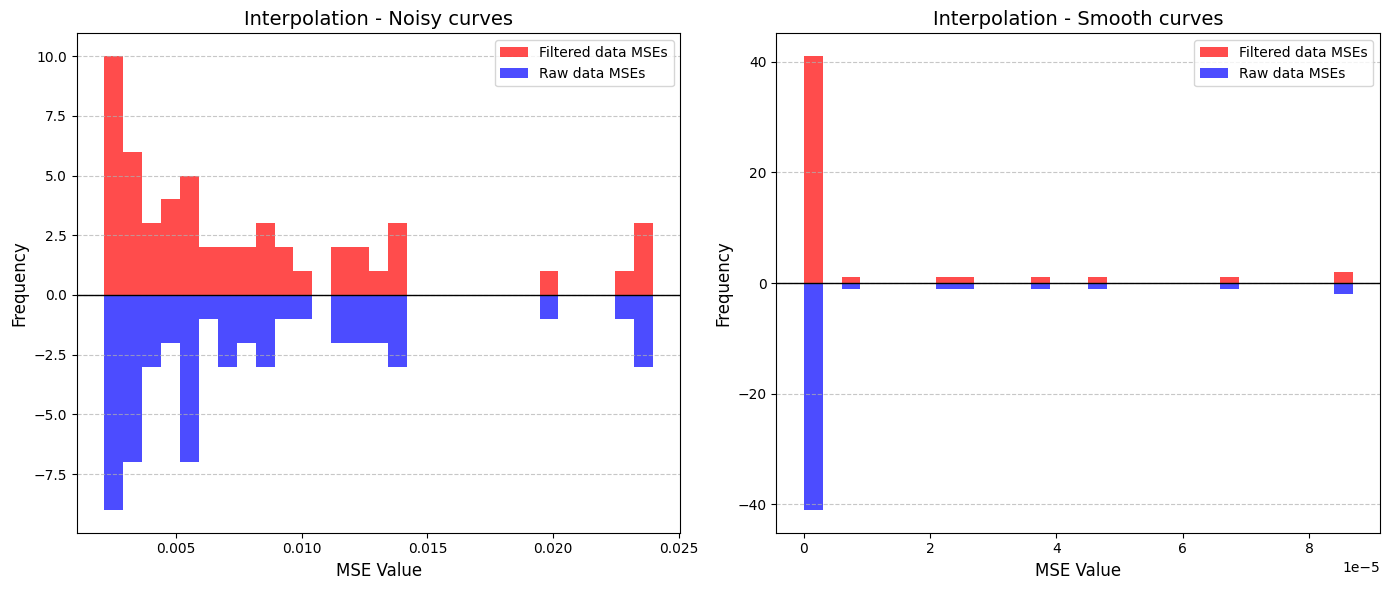

In [14]:
noisy_interpolation = [(0, 11), (0, 22), (8, 48), (7, 62), (7, 11), (10, 40), (10, 62), (10, 19), (8, 31), (0, 14), (10, 48), (0, 28), (8, 14), (8, 66), (8, 22), (11, 12), (4, 53), (10, 22), (7, 19), (11, 22), (13, 18), (8, 40), (8, 32), (0, 66), (5, 54), (10, 66), (8, 19), (12, 54), (7, 22), (5, 22), (0, 48), (10, 31), (8, 62), (0, 33), (8, 45), (22, 53), (5, 53), (8, 54), (0, 31), (10, 54), (0, 40), (10, 45), (10, 14), (7, 66), (11, 53), (0, 19), (5, 24), (8, 24), (11, 32), (7, 68), (7, 14), (5, 40), (8, 18), (5, 12), (10, 18), (4, 54), (12, 53), (7, 54), (7, 28), (8, 5)]
smooth_interpolation = [(18, 35), (23, 37), (17, 63), (18, 25), (21, 25), (23, 9), (23, 12), (23, 33), (23, 45), (20, 25), (18, 43), (23, 28), (23, 35), (20, 35), (22, 33), (23, 29), (23, 1), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 32), (23, 63), (23, 65), (23, 66), (23, 10), (23, 41), (23, 43), (23, 17), (23, 58), (23, 64), (23, 0), (23, 52), (23, 15), (23, 50), (23, 46), (23, 16), (23, 59), (23, 67), (23, 13), (23, 44), (23, 56), (23, 21), (23, 38), (23, 23), (23, 39), (23, 30), (23, 51), (23, 60), (23, 55), (23, 42), (23, 20), (23, 34), (23, 71), (23, 49), (23, 27), (23, 61), (23, 57), (23, 70)]

plot_mirror_histogram(True, noisy_interpolation, smooth_interpolation, False, 2.0)

# MSEs extrapolation (Noisy pairs)

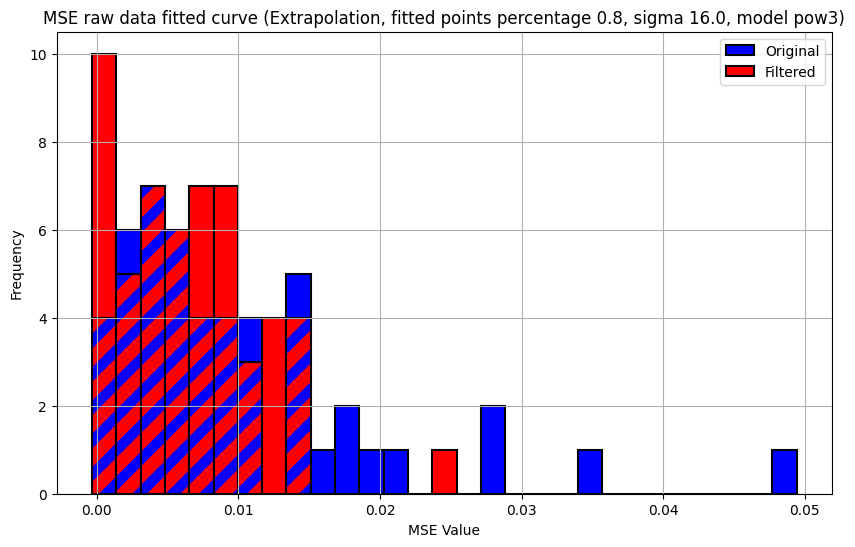

MannWhitney U
Statistic: 2244.0
P value: 0.01992425014076609


In [15]:
# generated noisy
extrapolation_pairs = [(0, 11), (0, 22), (8, 48), (7, 62), (7, 11), (10, 40), (10, 62), (10, 19), (8, 31), (0, 14), (10, 48), (0, 28), (8, 14), (8, 66), (8, 22), (11, 12), (4, 53), (10, 22), (7, 19), (11, 22), (13, 18), (8, 40), (8, 32), (0, 66), (5, 54), (10, 66), (8, 19), (12, 54), (7, 22), (5, 22), (0, 48), (10, 31), (8, 62), (0, 33), (8, 45), (22, 53), (5, 53), (8, 54), (0, 31), (10, 54), (0, 40), (10, 45), (10, 14), (7, 66), (11, 53), (0, 19), (5, 24), (8, 24), (11, 32), (7, 68), (7, 14), (5, 40), (8, 18), (5, 12), (10, 18), (4, 54), (12, 53), (7, 54), (7, 28), (8, 5)]

plot_mses(False, extrapolation_pairs, False, 16.0)

# MSEs extrapolation (Smooth pairs)

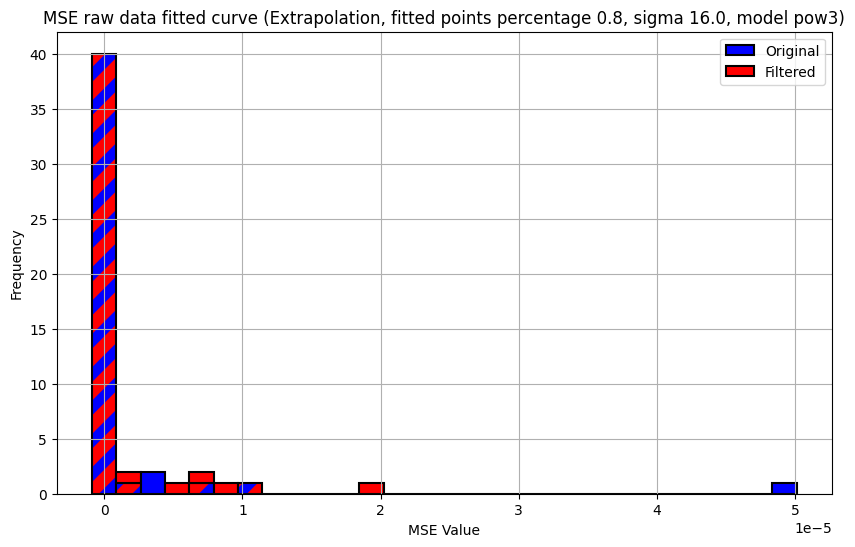

MannWhitney U
Statistic: 1889.5
P value: 0.6354688758093098


In [16]:
# generated smooth
extrapolation_pairs = [(18, 35), (23, 37), (17, 63), (18, 25), (21, 25), (23, 9), (23, 12), (23, 33), (23, 45), (20, 25), (18, 43), (23, 28), (23, 35), (20, 35), (22, 33), (23, 29), (23, 1), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 32), (23, 63), (23, 65), (23, 66), (23, 10), (23, 41), (23, 43), (23, 17), (23, 58), (23, 64), (23, 0), (23, 52), (23, 15), (23, 50), (23, 46), (23, 16), (23, 59), (23, 67), (23, 13), (23, 44), (23, 56), (23, 21), (23, 38), (23, 23), (23, 39), (23, 30), (23, 51), (23, 60), (23, 55), (23, 42), (23, 20), (23, 34), (23, 71), (23, 49), (23, 27), (23, 61), (23, 57), (23, 70)]

plot_mses(False, extrapolation_pairs, False, 16.0)

# MSEs extrapolation

## MSEs interpolation (Noisypairs)

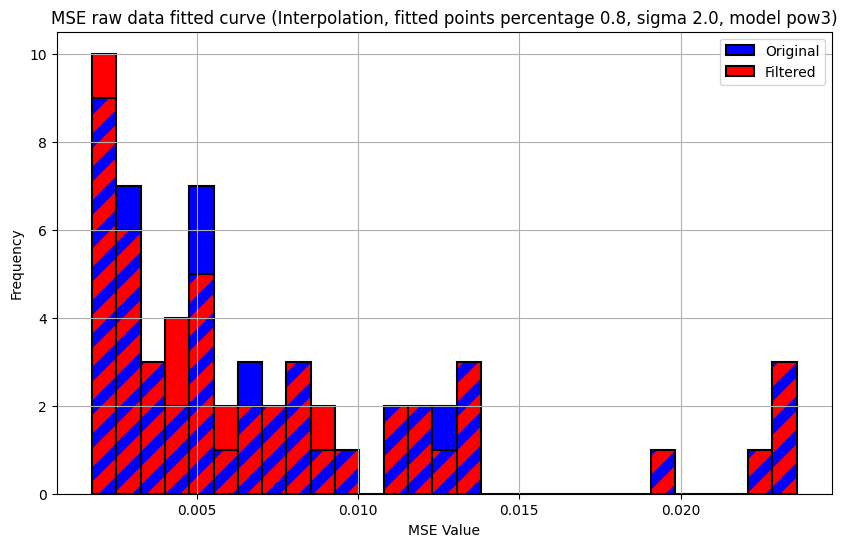

MannWhitney U
Statistic: 1824.0
P value: 0.9018354821522864


In [17]:
# noisy generated
interpolation_pairs = [(0, 11), (0, 22), (8, 48), (7, 62), (7, 11), (10, 40), (10, 62), (10, 19), (8, 31), (0, 14), (10, 48), (0, 28), (8, 14), (8, 66), (8, 22), (11, 12), (4, 53), (10, 22), (7, 19), (11, 22), (13, 18), (8, 40), (8, 32), (0, 66), (5, 54), (10, 66), (8, 19), (12, 54), (7, 22), (5, 22), (0, 48), (10, 31), (8, 62), (0, 33), (8, 45), (22, 53), (5, 53), (8, 54), (0, 31), (10, 54), (0, 40), (10, 45), (10, 14), (7, 66), (11, 53), (0, 19), (5, 24), (8, 24), (11, 32), (7, 68), (7, 14), (5, 40), (8, 18), (5, 12), (10, 18), (4, 54), (12, 53), (7, 54), (7, 28), (8, 5)]

plot_mses(True, interpolation_pairs, False, 2.0)

# MSEs interpolation (Smooth pairs)

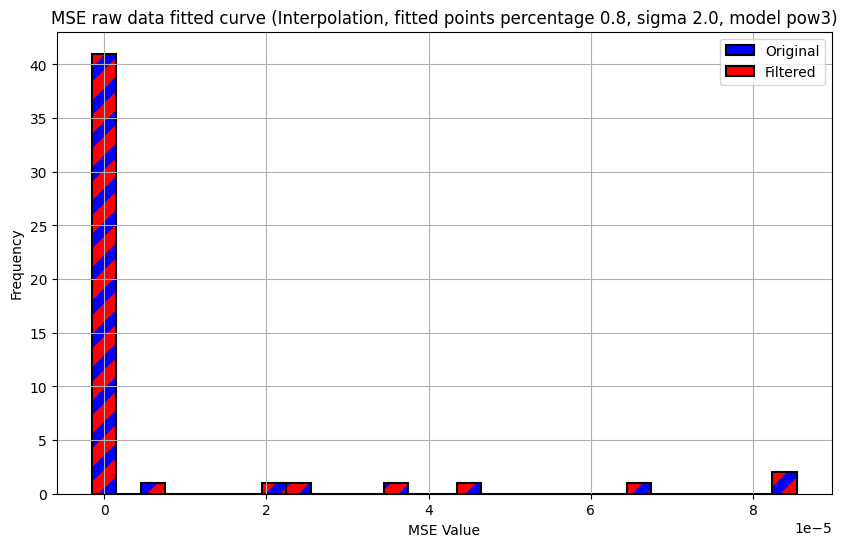

MannWhitney U
Statistic: 1794.5
P value: 0.9789386575842823


In [18]:
# smooth generated
interpolation_pairs = [(18, 35), (23, 37), (17, 63), (18, 25), (21, 25), (23, 9), (23, 12), (23, 33), (23, 45), (20, 25), (18, 43), (23, 28), (23, 35), (20, 35), (22, 33), (23, 29), (23, 1), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 32), (23, 63), (23, 65), (23, 66), (23, 10), (23, 41), (23, 43), (23, 17), (23, 58), (23, 64), (23, 0), (23, 52), (23, 15), (23, 50), (23, 46), (23, 16), (23, 59), (23, 67), (23, 13), (23, 44), (23, 56), (23, 21), (23, 38), (23, 23), (23, 39), (23, 30), (23, 51), (23, 60), (23, 55), (23, 42), (23, 20), (23, 34), (23, 71), (23, 49), (23, 27), (23, 61), (23, 57), (23, 70)]

plot_mses(True, interpolation_pairs, False, 2.0)

# Best Sigma for MSE ( extrapolation )

In [30]:
is_interpolation = False
# sigmas = [1.0, 2.5, 5.0, 10.0]
sigmas = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
learners = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23]

for learner_index in learners:
    avg_mse_originals_per_sigma = []
    avg_mse_filtereds_per_sigma = []
    
    for sigma in sigmas:
        all_orig = []
        all_filt = []
    
        pairs = []
        for dataset_index in range(len(dataset_ids)):
            pairs.append([learner_index, dataset_index])

        mse_originals, mse_filtereds = compute_mses(sigma, is_interpolation, pairs)
        mean_orig = np.mean(mse_originals)
        mean_filt = np.mean(mse_filtereds)
            
        avg_mse_originals_per_sigma.append(mean_orig)
        avg_mse_filtereds_per_sigma.append(mean_filt)

    avg_mse_originals_per_sigma = np.array(avg_mse_originals_per_sigma)
    avg_mse_filtereds_per_sigma = np.array(avg_mse_filtereds_per_sigma)

    print(f"Learner {learner_zoo[learner_index]}: avg. original MSE {avg_mse_originals_per_sigma[0]}; best filtered MSE {np.min(avg_mse_filtereds_per_sigma)} at sigma {sigmas[np.argmin(avg_mse_filtereds_per_sigma)]}")

Learner SVC_linear: avg. original MSE 0.051386267359134465; best filtered MSE 0.007560954476178855 at sigma 16.0
Learner SVC_poly: avg. original MSE 0.013715599730091187; best filtered MSE 0.0015331714684119686 at sigma 16.0
Learner SVC_rbf: avg. original MSE 0.020164614747982652; best filtered MSE 0.0021179803020695744 at sigma 16.0
Learner SVC_sigmoid: avg. original MSE 19249.80861222367; best filtered MSE 0.0049300558292118294 at sigma 16.0
Learner DecisionTree: avg. original MSE 0.013943147742585251; best filtered MSE 0.0012366038607233034 at sigma 16.0
Learner ExtraTree: avg. original MSE 0.0054078797787274; best filtered MSE 0.001626726845601884 at sigma 16.0
Learner LogisticRegression: avg. original MSE 0.006965986568563753; best filtered MSE 0.0008082829840940448 at sigma 16.0
Learner PassiveAggressive: avg. original MSE 0.02161233611210139; best filtered MSE 0.007103941593868338 at sigma 16.0
Learner Perceptron: avg. original MSE 0.038669280467532915; best filtered MSE 0.01251

# Best Sigma for MSE ( interpolation )

In [20]:
is_interpolation = True
# sigmas = [1.0, 2.5, 5.0, 10.0]
sigmas = [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0]
learners = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23]

for learner_index in learners:
    avg_mse_originals_per_sigma = []
    avg_mse_filtereds_per_sigma = []
    
    for sigma in sigmas:
        all_orig = []
        all_filt = []
    
        pairs = []
        for dataset_index in range(len(dataset_ids)):
            pairs.append([learner_index, dataset_index])

        mse_originals, mse_filtereds = compute_mses(sigma, is_interpolation, pairs)
        mean_orig = np.mean(mse_originals)
        mean_filt = np.mean(mse_filtereds)
            
        avg_mse_originals_per_sigma.append(mean_orig)
        avg_mse_filtereds_per_sigma.append(mean_filt)

    avg_mse_originals_per_sigma = np.array(avg_mse_originals_per_sigma)
    avg_mse_filtereds_per_sigma = np.array(avg_mse_filtereds_per_sigma)

    print(f"Learner {learner_zoo[learner_index]}: avg. original MSE {avg_mse_originals_per_sigma[0]}; best filtered MSE {np.min(avg_mse_filtereds_per_sigma)} at sigma {sigmas[np.argmin(avg_mse_filtereds_per_sigma)]}")

Learner SVC_linear: avg. original MSE 0.006829837031552854; best filtered MSE 0.0068117500661052715 at sigma 2.0
Learner SVC_poly: avg. original MSE 0.001003774768375436; best filtered MSE 0.0010009415466088838 at sigma 2.0
Learner SVC_rbf: avg. original MSE 0.0017893857725757123; best filtered MSE 0.0017837976094660962 at sigma 2.0
Learner SVC_sigmoid: avg. original MSE 0.002194622970289518; best filtered MSE 0.002139581562413873 at sigma 2.0
Learner DecisionTree: avg. original MSE 0.0018144094671394342; best filtered MSE 0.0018026989326985097 at sigma 4.0
Learner ExtraTree: avg. original MSE 0.0016953490063425945; best filtered MSE 0.0016941893266856302 at sigma 0.5
Learner LogisticRegression: avg. original MSE 0.0012774628507784165; best filtered MSE 0.0012641708124586117 at sigma 4.0
Learner PassiveAggressive: avg. original MSE 0.007795111467823577; best filtered MSE 0.0077699761134619166 at sigma 1.0
Learner Perceptron: avg. original MSE 0.011650951291321883; best filtered MSE 0.0

# Find noisy datasets

smooth: [(18, 35), (23, 37), (17, 63), (18, 25), (21, 25), (23, 9), (23, 12), (23, 33), (23, 45), (20, 25), (18, 43), (23, 28), (23, 35), (20, 35), (22, 33), (23, 29), (23, 1), (23, 3), (23, 4), (23, 6), (23, 7), (23, 8), (23, 32), (23, 63), (23, 65), (23, 66), (23, 10), (23, 41), (23, 43), (23, 17), (23, 58), (23, 64), (23, 0), (23, 52), (23, 15), (23, 50), (23, 46), (23, 16), (23, 59), (23, 67), (23, 13), (23, 44), (23, 56), (23, 21), (23, 38), (23, 23), (23, 39), (23, 30), (23, 51), (23, 60), (23, 55), (23, 42), (23, 20), (23, 34), (23, 71), (23, 49), (23, 27), (23, 61), (23, 57), (23, 70)]
noisy: [(0, 11), (0, 22), (8, 48), (7, 62), (7, 11), (10, 40), (10, 62), (10, 19), (8, 31), (0, 14), (10, 48), (0, 28), (8, 14), (8, 66), (8, 22), (11, 12), (4, 53), (10, 22), (7, 19), (11, 22), (13, 18), (8, 40), (8, 32), (0, 66), (5, 54), (10, 66), (8, 19), (12, 54), (7, 22), (5, 22), (0, 48), (10, 31), (8, 62), (0, 33), (8, 45), (22, 53), (5, 53), (8, 54), (0, 31), (10, 54), (0, 40), (10, 45),

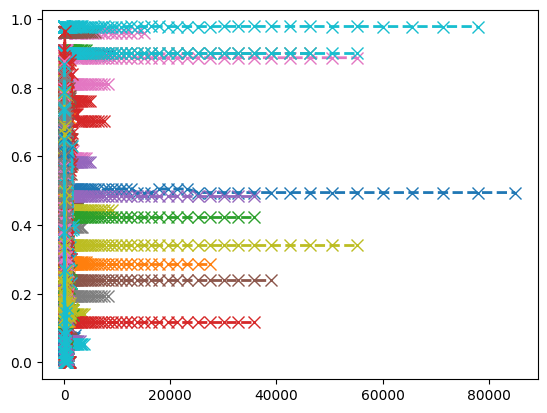

In [31]:
def median_absolute_deviation(arr):
    arr = np.array(arr)
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def noise(x, y):
    x = np.array(x)
    y = np.array(y)

    dx = np.diff(x)
    dy = np.diff(y)

    small_eps = 1e-14
    slopes = dy/(dx+small_eps)

    return median_absolute_deviation(slopes)

def noisex(x, y):
    x = np.array(x)
    y = np.array(y)

    ddx = np.diff(x, n=2)
    ddy = np.diff(y, n=2)

    accel = np.sqrt(ddx**2 + ddy**2)
    accel_std = np.std(accel)
    return accel_std
    
data = []
for learner_index in range(len(learner_zoo)):
    for dataset_index in range(len(dataset_ids)):
        inner_split = 0
        outer_split = 0
        
        validation_error_rates = dataset[dataset_index, learner_index, outer_split, inner_split,:, 1]
        
        first_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][0] if np.any(~np.isnan(validation_error_rates)) else -1
        last_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][-1] if np.any(~np.isnan(validation_error_rates)) else -1
        resized_validation_error_rates = validation_error_rates[first_non_nan_index:last_non_nan_index + 1]
        resized_anchor_list_denser = anchor_list_denser[first_non_nan_index:last_non_nan_index + 1]

        data.append((learner_index, dataset_index, noise(resized_validation_error_rates, resized_anchor_list_denser)))

data.sort(key=lambda x: x[2])

COUNT = 60
print(f"smooth: {[(data[0], data[1]) for data in data[-COUNT:]]}")
print(f"noisy: {[(data[0], data[1]) for data in data[:COUNT]]}")

for learner_index, dataset_index, noise in data[-COUNT:]:
    print(f"Noise {noise}")
    validation_error_rates = dataset[dataset_index, learner_index, outer_split, inner_split,:, 1]

    first_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][0] if np.any(~np.isnan(validation_error_rates)) else -1
    last_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][-1] if np.any(~np.isnan(validation_error_rates)) else -1
    resized_validation_error_rates = validation_error_rates[first_non_nan_index:last_non_nan_index + 1]
    resized_anchor_list_denser = anchor_list_denser[first_non_nan_index:last_non_nan_index + 1]
    plt.plot(resized_anchor_list_denser, resized_validation_error_rates, label="Validation LC(Raw)", marker='x', markersize=8, linestyle='--', linewidth=2)
    
for learner_index, dataset_index, noise in data[:COUNT]:
    print(f"Noise {noise}")
    validation_error_rates = dataset[dataset_index, learner_index, outer_split, inner_split,:, 1]

    first_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][0] if np.any(~np.isnan(validation_error_rates)) else -1
    last_non_nan_index = np.where(~np.isnan(validation_error_rates))[0][-1] if np.any(~np.isnan(validation_error_rates)) else -1
    resized_validation_error_rates = validation_error_rates[first_non_nan_index:last_non_nan_index + 1]
    resized_anchor_list_denser = anchor_list_denser[first_non_nan_index:last_non_nan_index + 1]
    plt.plot(resized_anchor_list_denser, resized_validation_error_rates, label="Validation LC(Raw)", marker='x', markersize=8, linestyle='--', linewidth=2)